# Integrated Error Models

In addition to creating your own error models to evaluate pre-trained models, error models can also be built alongside a model.

In [1]:
import olorenchemengine as oce
import pandas as pd
import numpy as np
import json
import tqdm

import matplotlib.pyplot as plt
from scipy.stats import linregress

dataset = oce.load('lipophilicity_dataset.oce')
model = oce.RandomForestModel(oce.OlorenCheckpoint("default"), n_estimators=1000)

To build an error model during model training, simply input the error model you wish to use. Here, we will use the ```oce.SDC``` error model.

In [2]:
error_model = oce.SDC(ci=0.8)
model.fit(dataset.train_dataset[0], dataset.train_dataset[1], error_model=error_model)

The error model is now built and stored in ```model.error_model```. From here, any error model methods, such as ```.train()``` and ```.train_cv()``` for aggregate error models, or ```.fit()``` and ```.fit_cv()``` for all error models, can be run. Note that by default, ```.train``` is not run for aggregate error models, and must be run individually before model fitting.

Fitting can also be done when running ```model.test()``` by setting ```fit_error_model=True```.

100%|██████████| 420/420 [00:02<00:00, 185.78it/s]


{'r2': -0.2165032208945621,
 'Spearman': 0.615775101860648,
 'Explained Variance': 0.12270972573754768,
 'Max Error': 2.8227665528083024,
 'Mean Absolute Error': 1.1754660768776668,
 'Mean Squared Error': 1.8730372062735476,
 'Root Mean Squared Error': 1.3685894951641078}

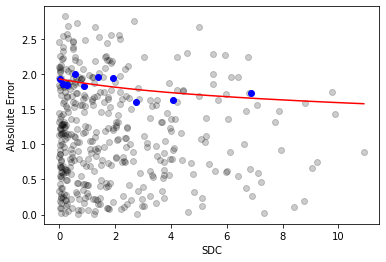

In [3]:
model.test(dataset.valid_dataset[0], dataset.valid_dataset[1], fit_error_model=True)

Finally, if a model contains a fitted error model, setting ```return_ci=True``` when running ```model.predict()``` will return the confidence intervals. Setting ```return_vis=True``` will in turn return ```VisualizeError``` objects.

In [4]:
df = model.predict(dataset.test_dataset[0], return_ci=True, return_vis=True)

100%|██████████| 420/420 [00:02<00:00, 185.62it/s]


In [5]:
df.head()

,predicted,ci,vis
0,1.330451,1.667920,<olorenchemengine.visualizations.visualization...
1,1.449817,1.918109,<olorenchemengine.visualizations.visualization...
2,1.300253,1.898922,<olorenchemengine.visualizations.visualization...
3,1.664629,1.914140,<olorenchemengine.visualizations.visualization...
4,1.340144,1.921038,<olorenchemengine.visualizations.visualization...


In [6]:
df.vis[0].render_ipynb()

# Production Level Models

Production level models use the entire dataset to train the model. As such, metrics and error model training and fitting are done via cross validation. The entire process can be done by calling the ```.fit_cv()``` function.

In [ ]:
model = oce.RandomForestModel(oce.OlorenCheckpoint("default"), n_estimators=1000)
error_model = oce.SDC()

model.fit_cv(dataset.entire_dataset[0], dataset.entire_dataset[1], error_model=error_model, ci = 0.8, scoring = "r2")

The trained error model will be stored in ```model.error_model```